In the previous notebook, we covered the following key concepts:

- **Embeddings**:
  - Defined as dense vector representations of tokens that capture their meanings.
  - Implemented using PyTorch to create an embedding layer for the sentence "The cat sat on the mat."
  - Mapped tokens to unique IDs and converted them to embeddings.

- **Positional Encoding**:
  - Provided information about the position of each token in a sequence.
  - Implemented a function to generate positional encodings using sine and cosine functions.
  - Combined positional encodings with embeddings to create context-aware representations.


In today’s session, we will focus on two crucial concepts in the transformer architecture:

1. **Self-Attention**: Understanding how the model evaluates the significance of each word in relation to others in a sentence.
2. **Multi-Head Self-Attention**: Exploring how multiple attention mechanisms work together to capture different aspects of the input.

Let’s dive into the first topic: **Self-Attention**.

-----

# Self-Attention

## What is Self-Attention?

Self-attention is a mechanism that allows the model to weigh the importance of each word in a sentence relative to all other words. It helps the model focus on relevant information, enabling a richer understanding of language.

Consider the task of translating a sentence from one language to another. Translating a sentence word-by-word does not work effectively because it fails to capture the context and relationships between words.

For example, let's say we have the French sentence:
- **"Le chat noir mange la souris blanche."**

Translating each word individually to English would result in:
- **"The black cat eats the white mouse."**

However, this translation does not accurately convey the meaning because it doesn't consider the context and order of words. Self-attention can help address this issue by allowing the model to focus on relevant words based on their relationships.

## How Self-Attention Works

Let's break down the self-attention mechanism step by step, using a simple sentence as an example.


### Step 1: Input Representation

   - Each word in the input sentence is transformed into a vector representation using embeddings. These embeddings capture the meanings of words in a multi-dimensional space.

**Embeddings**:
- Let's assume the embeddings for our French tokens are as follows:

| Token | Embedding Vector          |
|-------|---------------------------|
| Le    | [0.1, 0.2, 0.3]           |
| chat  | [0.4, 0.5, 0.6]           |
| noir  | [0.7, 0.8, 0.9]           |
| mange | [0.1, 0.4, 0.7]           |
| la    | [0.1, 0.2, 0.3]           |
| souris| [0.3, 0.6, 0.9]           |
| blanche| [0.7, 0.8, 0.9]          |
|  **.**     | [0.1, 0.1, 0.1]          |


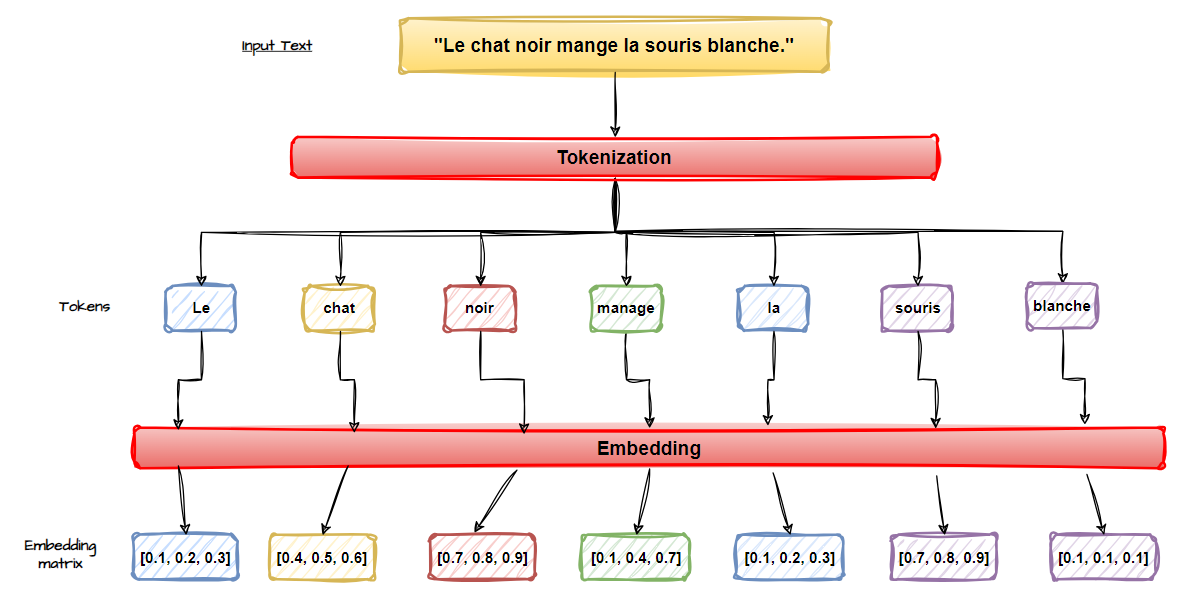

In [7]:
import torch
import torch.nn as nn

# Define the vocabulary and embeddings
tokens = ["Le", "chat", "noir", "mange", "la", "souris", "blanche"]

embeddings_dict = {
    "Le": [0.1, 0.2, 0.3],
    "chat": [0.4, 0.5, 0.6],
    "noir": [0.7, 0.8, 0.9],
    "mange": [0.1, 0.4, 0.7],
    "la": [0.1, 0.2, 0.3],
    "souris": [0.3, 0.6, 0.9],
    "blanche": [0.7, 0.8, 0.9],
}

In [11]:
# Convert tokens to embeddings
embeddings = torch.tensor([embeddings_dict[token] for token in tokens], dtype=torch.float32)
print("Embeddings:\n", embeddings)

Embeddings:
 tensor([[0.1000, 0.2000, 0.3000],
        [0.4000, 0.5000, 0.6000],
        [0.7000, 0.8000, 0.9000],
        [0.1000, 0.4000, 0.7000],
        [0.1000, 0.2000, 0.3000],
        [0.3000, 0.6000, 0.9000],
        [0.7000, 0.8000, 0.9000]])


### Step 2: Creating Query, Key, and Value Vectors

   - Each word’s embedding is transformed into three vectors:
     - **Query (Q)**: Represents the word currently being focused on.
     - **Key (K)**: Represents all other words in the sequence.
     - **Value (V)**: Holds the actual information used in the output.
   - This transformation is done through learned linear projections:
     - $$ Q = W_Q \cdot x $$
     - $$ K = W_K \cdot x $$
     - $$ V = W_V \cdot x $$
   - Where $$ W_Q, W_K, W_V $$ are weight matrices learned during training.

**Transformations**:
- For simplicity, let's assume learned weight matrices are as follows:

| Weight Matrix | Q     | K     | V     |
|---------------|-------|-------|-------|
| W_Q           | [1, 0] | [0, 1] | [1, 1] |
| W_K           | [1, 0] | [0, 1] | [1, 1] |
| W_V           | [1, 0] | [0, 1] | [1, 1] |


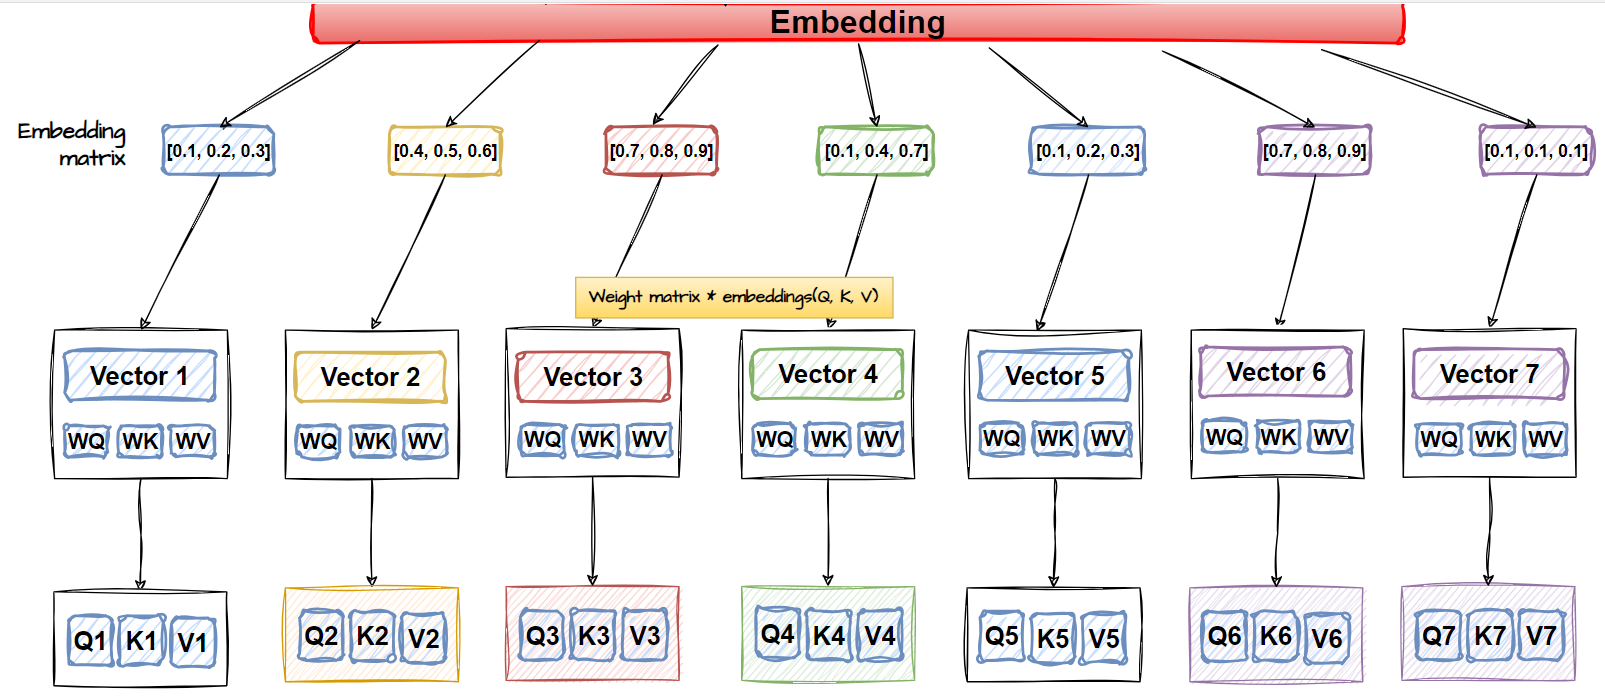

In [12]:
# Define weight matrices for Q, K, V (3 input features, 2 output features)
W_Q = torch.tensor([[1, 0], [0, 1], [1, 1]], dtype=torch.float32)  # Shape (3, 2)
W_K = torch.tensor([[1, 0], [0, 1], [1, 1]], dtype=torch.float32)  # Shape (3, 2)
W_V = torch.tensor([[1, 0], [0, 1], [1, 1]], dtype=torch.float32)  # Shape (3, 2)

In [13]:
# Create Q, K, V vectors for each word
Q = torch.matmul(embeddings, W_Q)  # Shape (7, 2)
K = torch.matmul(embeddings, W_K)  # Shape (7, 2)
V = torch.matmul(embeddings, W_V)  # Shape (7, 2)

In [14]:
print("Query Vectors:\n", Q)
print("Key Vectors:\n", K)
print("Value Vectors:\n", V)

Query Vectors:
 tensor([[0.4000, 0.5000],
        [1.0000, 1.1000],
        [1.6000, 1.7000],
        [0.8000, 1.1000],
        [0.4000, 0.5000],
        [1.2000, 1.5000],
        [1.6000, 1.7000]])
Key Vectors:
 tensor([[0.4000, 0.5000],
        [1.0000, 1.1000],
        [1.6000, 1.7000],
        [0.8000, 1.1000],
        [0.4000, 0.5000],
        [1.2000, 1.5000],
        [1.6000, 1.7000]])
Value Vectors:
 tensor([[0.4000, 0.5000],
        [1.0000, 1.1000],
        [1.6000, 1.7000],
        [0.8000, 1.1000],
        [0.4000, 0.5000],
        [1.2000, 1.5000],
        [1.6000, 1.7000]])


### Step 3: Calculating Attention Scores

   - The model calculates a score for each word indicating how much attention should be paid to every other word:
     $$ \text{score}(Q, K) = Q \cdot K^T $$
   - The resulting scores indicate the relevance of each word relative to the word being processed.


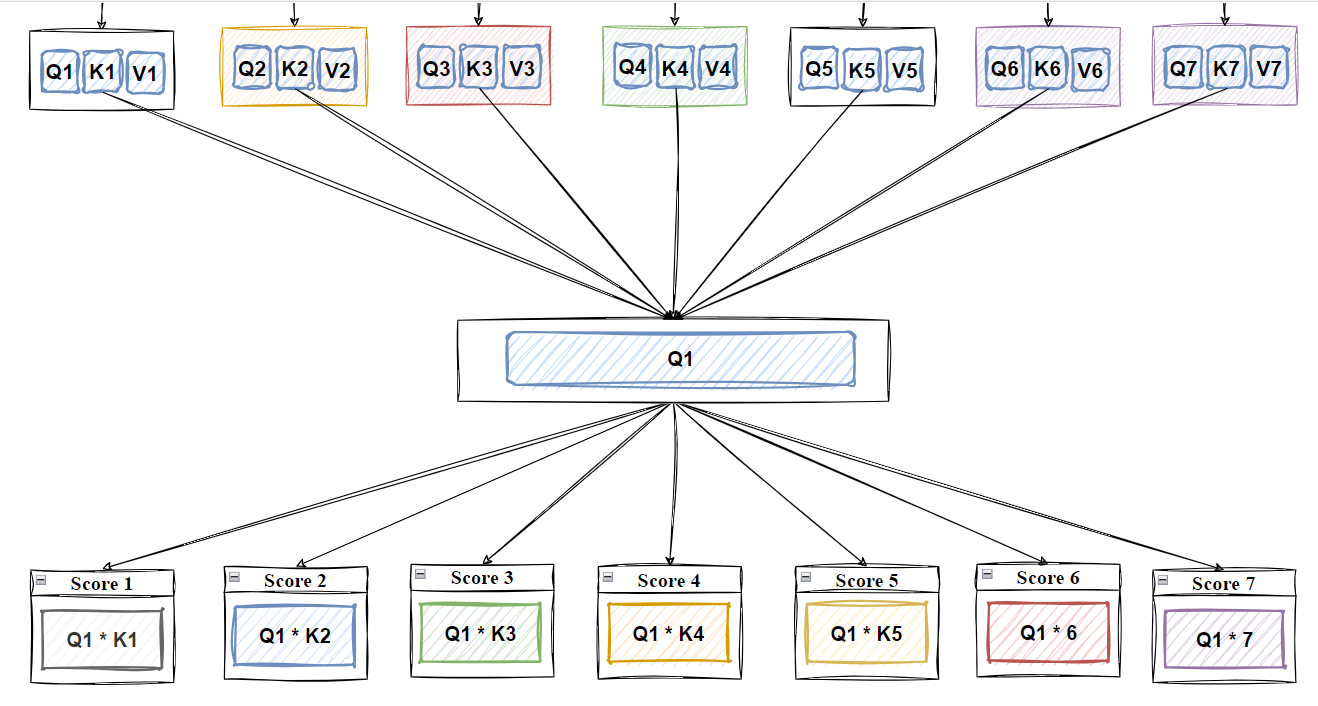

In [15]:
# Calculate attention scores for the first word "Le"
attention_scores = torch.matmul(Q[0], K.T)
print("Attention Scores for 'Le':\n", attention_scores)

Attention Scores for 'Le':
 tensor([0.4100, 0.9500, 1.4900, 0.8700, 0.4100, 1.2300, 1.4900])


- The attention scores represent how much each word in the sequence contributes to the meaning of the word "Le." These scores are calculated by taking the dot product of the Query vector for **`"Le"`** with the Key vectors of all words.
- The highest scores are for **`"noir"` (1.4900)** and **`"blanche"` (1.4900)**, indicating that **`"Le"`** is most strongly related to these words.
- The next highest scores are for **`"souris"` (1.2300)** and **`"chat"` (0.9500)**, suggesting that **`"Le"`** is also related to these words, but to a lesser degree than "noir" and "blanche."
- The lowest scores are for **`"la"` (0.4100)** and **`"mange"` (0.8700)**, implying that these words have the least direct relationship with **`"Le"`** in the given context.

### Step 4: Normalizing Scores

   - Scores are normalized using the softmax function to convert them into probabilities, ensuring all attention weights sum to 1:
     - $$ \text{attention\_weights} = \text{softmax}\left(\frac{\text{score}(Q, K)}{\sqrt{d_k}}\right) $$
   - Here, $$ d_k $$ is the dimension of the Key vectors, and the division by $$ \sqrt{d_k} $$ helps stabilize gradients during training.

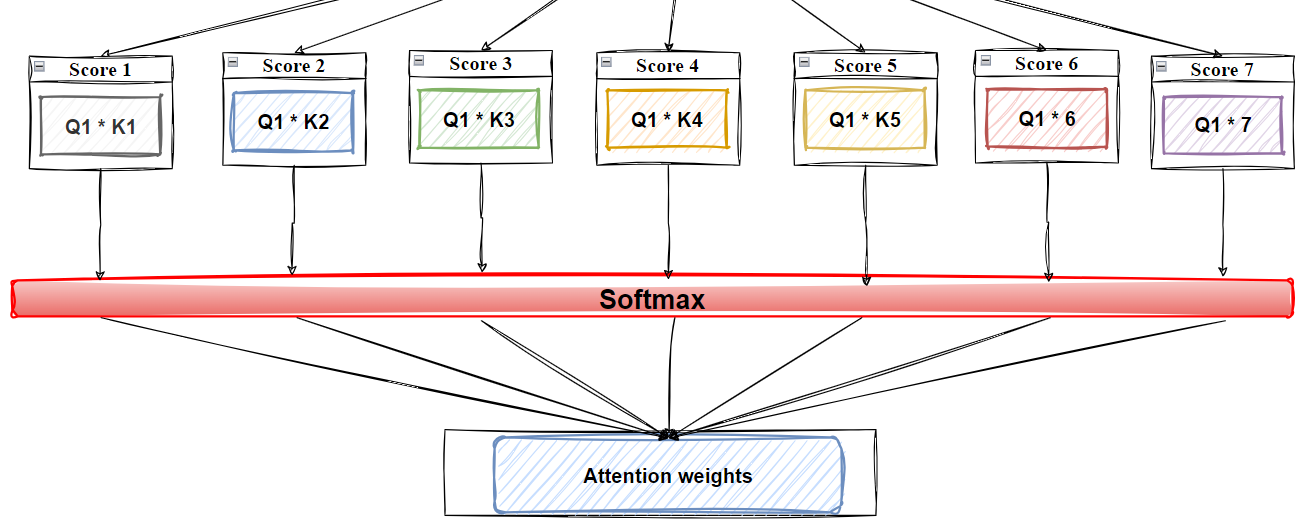

In [16]:
# Normalize scores using softmax
attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)
print("Attention Weights for 'Le':\n", attention_weights)

Attention Weights for 'Le':
 tensor([0.0743, 0.1275, 0.2188, 0.1177, 0.0743, 0.1687, 0.2188])


- The highest weights are for **`"noir"` (0.2188)** and **`"blanche"` (0.2188)**, indicating that these words contribute the most to the meaning of **`"Le."`**
- **`"souris"` (0.1687)** and **`"chat"` (0.1275)** have the next highest weights, suggesting they are also important in determining the meaning of **`"Le."`**
- **`"la"` (0.0743)** and **`"mange"` (0.1177)** have the lowest weights, implying they contribute the least to the meaning of **`"Le"`** in this context.

### Step 5: Weighted Sum of Values

   - The attention weights are used to compute a weighted sum of the Value vectors:
     - $$ \text{output} = \sum (\text{attention\_weights} \cdot V) $$
   - This output vector represents contextualized information for the word being processed, incorporating relevant information from all other words in the sequence.


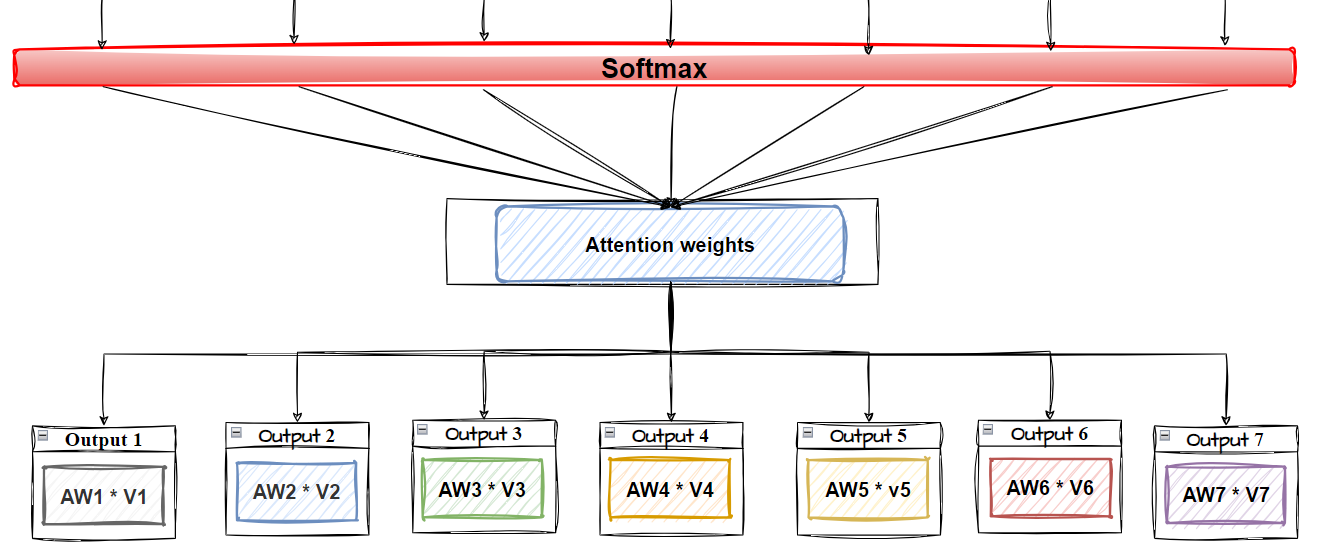

In [17]:
# Compute the weighted sum of Value vectors
output = torch.matmul(attention_weights.unsqueeze(0), V)
print("Output Vector for 'Le':\n", output)

Output Vector for 'Le':
 tensor([[1.1836, 1.3408]])


- This vector represents the contextualized information for **`"Le,"`** incorporating relevant information from all other words in the sentence.
- The output vector **tensor`([[1.1836, 1.3408]])`** combines information from the words that were deemed most relevant, particularly **`"chat"`** and **`"noir."`**

### Why is Self-Attention Important?

Self-attention allows the model to dynamically adjust its focus based on the context of the sentence, leading to a richer understanding of language. In the case of translation, self-attention helps the model capture the relationships between words, enabling more accurate translations that consider the context.

----

# Multi-Head Attention: How It Works

Multi-head attention is an extension of the self-attention mechanism that allows the model to focus on different parts of the input sequence simultaneously. Instead of having a single attention mechanism, multi-head attention uses multiple attention heads, each capable of learning different representations of the input.

## What is Multi-Head Attention?

Multi-head attention uses multiple attention mechanisms (heads) to capture various aspects of the input simultaneously.

## Key Differences from Self-Attention

- **Single vs. Multiple Heads**:

  - **Self-Attention**: Computes attention scores using a single set of Query (Q), Key (K), and Value (V) vectors for each word. It focuses on the relationships between words in a straightforward manner.
  - **Multi-Head Attention**: Utilizes multiple sets of Q, K, and V vectors (multiple heads), each learning to focus on different aspects of the input. This allows the model to capture a wider range of relationships and nuances.

- **Diverse Perspectives**:

  - Each attention head can specialize in different types of relationships. For instance, one head might focus on syntactic relationships (like subject-verb pairs), while another captures semantic meanings (like adjectives describing nouns).

## How Multi-Head Attention Works

Let’s illustrate how multi-head attention operates using a simple example.

1. **Input Representation**:
   - Each word in the input sentence is represented as an embedding vector. For example:
     - "Le": [0.1, 0.2, 0.3]
     - "chat": [0.4, 0.5, 0.6]
     - "noir": [0.7, 0.8, 0.9]
     - "mange": [0.1, 0.4, 0.7]
     - "la": [0.1, 0.2, 0.3]
     - "souris": [0.3, 0.6, 0.9]
     - "blanche": [0.7, 0.8, 0.9]

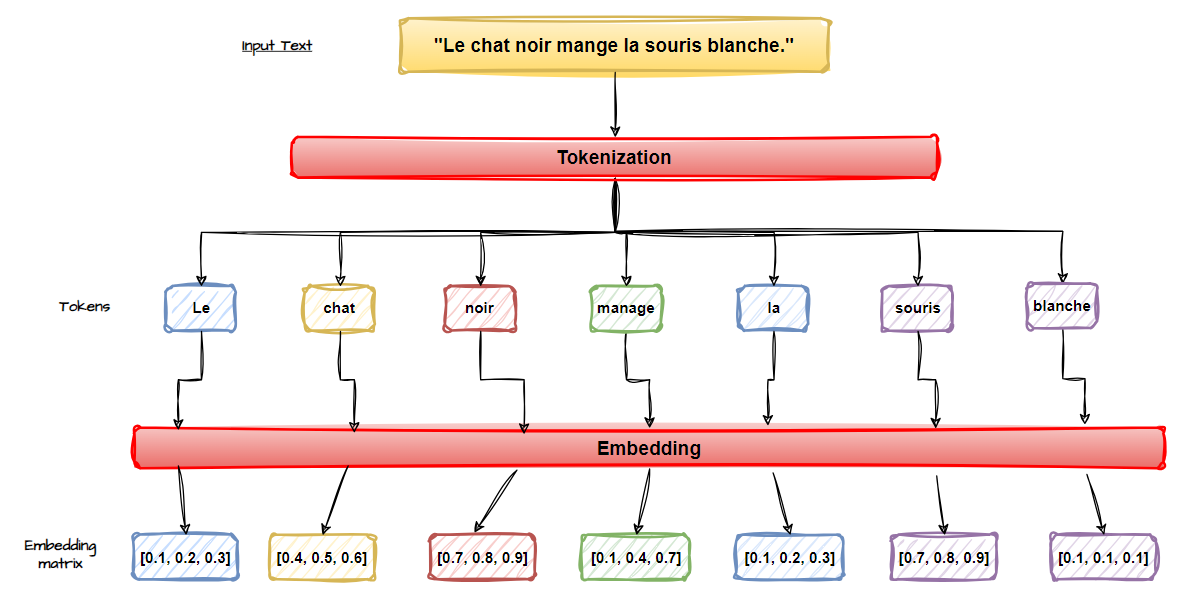

In [17]:
import torch

# Define the vocabulary and embeddings
tokens = ["Le", "chat", "noir", "mange", "la", "souris", "blanche"]
embeddings_dict = {
    "Le": [0.1, 0.2, 0.3],
    "chat": [0.4, 0.5, 0.6],
    "noir": [0.7, 0.8, 0.9],
    "mange": [0.1, 0.4, 0.7],
    "la": [0.1, 0.2, 0.3],
    "souris": [0.3, 0.6, 0.9],
    "blanche": [0.7, 0.8, 0.9],
}

# Convert tokens to embeddings
embeddings = torch.tensor([embeddings_dict[token] for token in tokens], dtype=torch.float32)
print("Input Embeddings:")
for token, embedding in zip(tokens, embeddings):
    print(f"{token}: {embedding}")

Input Embeddings:
Le: tensor([0.1000, 0.2000, 0.3000])
chat: tensor([0.4000, 0.5000, 0.6000])
noir: tensor([0.7000, 0.8000, 0.9000])
mange: tensor([0.1000, 0.4000, 0.7000])
la: tensor([0.1000, 0.2000, 0.3000])
souris: tensor([0.3000, 0.6000, 0.9000])
blanche: tensor([0.7000, 0.8000, 0.9000])


2. **Creating Q, K, and V Vectors**:
   - For each word, we create three sets of vectors: Query (Q), Key (K), and Value (V) using learned weight matrices.
   - For example, for the word "chat":
     - Query: $$ Q = W_Q \cdot \text{embedding} $$
     - Key: $$ K = W_K \cdot \text{embedding} $$
     - Value: $$ V = W_V \cdot \text{embedding} $$

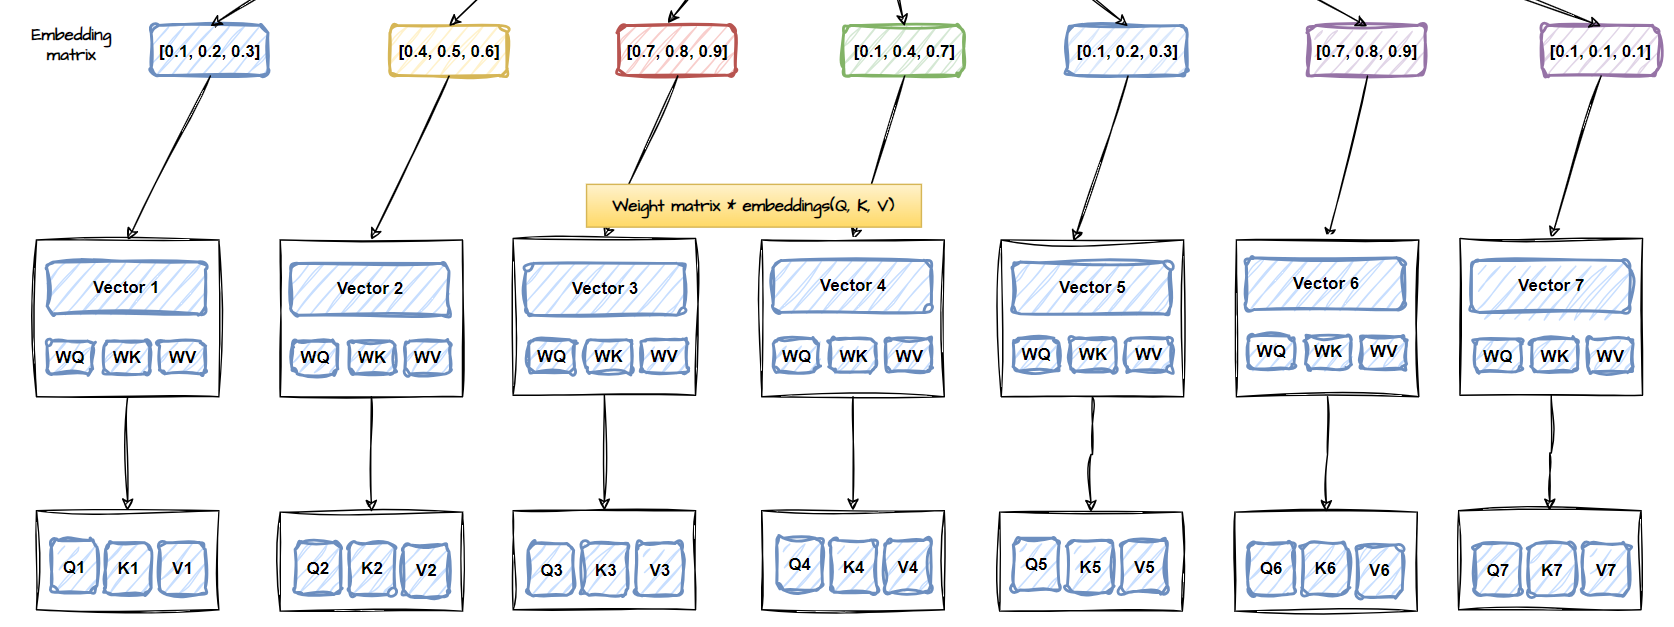

In [18]:
# Define weight matrices for Q, K, V (3 input features, 2 output features)
W_Q = torch.tensor([[1, 0], [0, 1], [1, 1]], dtype=torch.float32)  # Shape (3, 2)
W_K = torch.tensor([[1, 0], [0, 1], [1, 1]], dtype=torch.float32)  # Shape (3, 2)
W_V = torch.tensor([[1, 0], [0, 1], [1, 1]], dtype=torch.float32)  # Shape (3, 2)

# Create Q, K, V vectors for each word
Q = torch.matmul(embeddings, W_Q)  # Shape (7, 2)
K = torch.matmul(embeddings, W_K)  # Shape (7, 2)
V = torch.matmul(embeddings, W_V)  # Shape (7, 2)

print("\nQuery Vectors:")
for token, q in zip(tokens, Q):
    print(f"{token}: {q}")

print("\nKey Vectors:")
for token, k in zip(tokens, K):
    print(f"{token}: {k}")

print("\nValue Vectors:")
for token, v in zip(tokens, V):
    print(f"{token}: {v}")


Query Vectors:
Le: tensor([0.4000, 0.5000])
chat: tensor([1.0000, 1.1000])
noir: tensor([1.6000, 1.7000])
mange: tensor([0.8000, 1.1000])
la: tensor([0.4000, 0.5000])
souris: tensor([1.2000, 1.5000])
blanche: tensor([1.6000, 1.7000])

Key Vectors:
Le: tensor([0.4000, 0.5000])
chat: tensor([1.0000, 1.1000])
noir: tensor([1.6000, 1.7000])
mange: tensor([0.8000, 1.1000])
la: tensor([0.4000, 0.5000])
souris: tensor([1.2000, 1.5000])
blanche: tensor([1.6000, 1.7000])

Value Vectors:
Le: tensor([0.4000, 0.5000])
chat: tensor([1.0000, 1.1000])
noir: tensor([1.6000, 1.7000])
mange: tensor([0.8000, 1.1000])
la: tensor([0.4000, 0.5000])
souris: tensor([1.2000, 1.5000])
blanche: tensor([1.6000, 1.7000])


3. **Multiple Attention Heads**:
   - Instead of using a single set of Q, K, and V vectors, multi-head attention uses multiple sets (heads) to capture different aspects of the relationships between words.
   - For instance, Head 1 might focus on the relationship between "chat" and "noir," while Head 2 might focus on the relationship between "mange" and "souris."

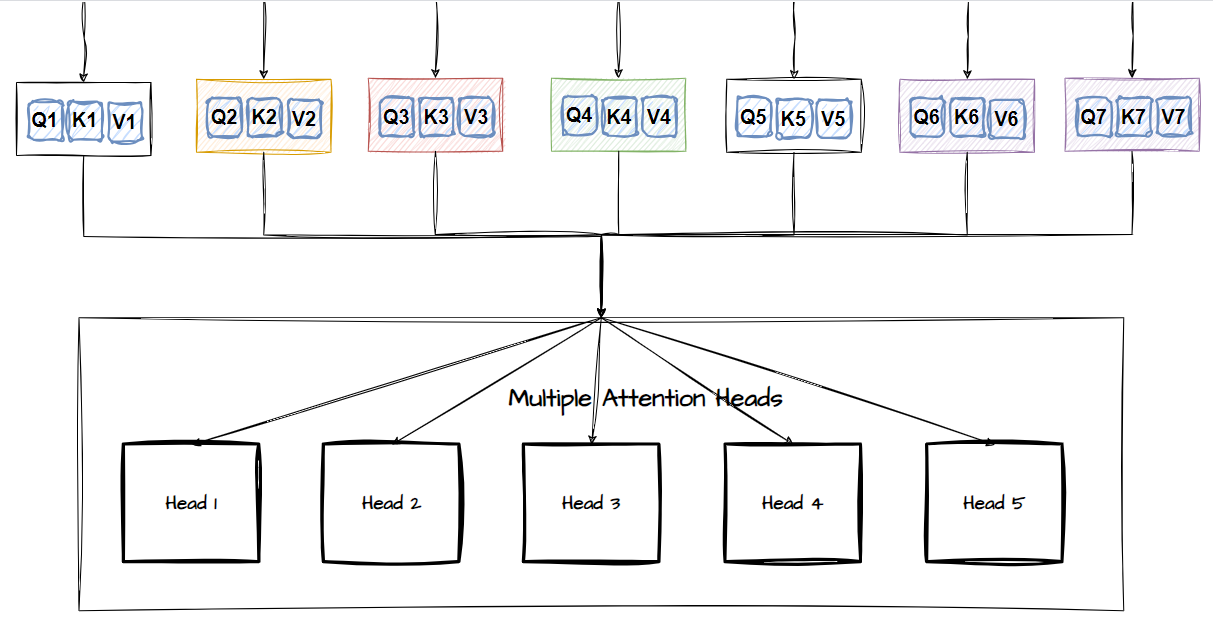

In [20]:
# Define the number of heads
num_heads = 2

# Split Q, K, V into multiple heads
def split_heads(x, num_heads):
    batch_size = x.size(0)
    depth = x.size(1) // num_heads
    x = x.view(batch_size, -1, num_heads, depth)  # Reshape to (batch_size, seq_length, num_heads, depth)
    return x.permute(0, 2, 1, 3)  # Rearrange to (batch_size, num_heads, seq_length, depth)

Q_heads = split_heads(Q, num_heads)
K_heads = split_heads(K, num_heads)
V_heads = split_heads(V, num_heads)

print("\nQ Heads Shape:\n", Q_heads.shape)
print("K Heads Shape:\n", K_heads.shape)
print("V Heads Shape:\n", V_heads.shape)


Q Heads Shape:
 torch.Size([7, 2, 1, 1])
K Heads Shape:
 torch.Size([7, 2, 1, 1])
V Heads Shape:
 torch.Size([7, 2, 1, 1])


4. **Computing Attention Scores**:
   - Each head computes attention scores by taking the dot product of the Query vector of each word with the Key vectors of all words.
   - This allows each head to determine how much attention to pay to each word when processing the input.

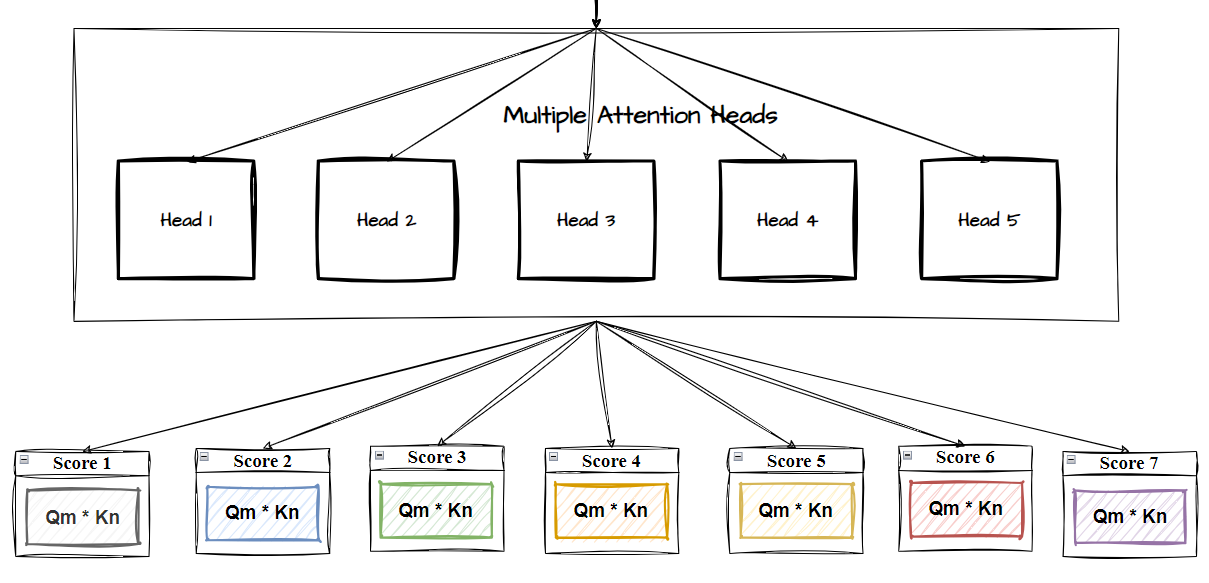

In [21]:
# Calculate attention scores for each head
def calculate_attention_scores(Q, K):
    scores = torch.matmul(Q, K.transpose(-2, -1))  # Shape: (batch_size, num_heads, seq_length, seq_length)
    return scores

attention_scores_heads = calculate_attention_scores(Q_heads, K_heads)
print("\nAttention Scores:")
for head_idx in range(num_heads):
    print(f"Head {head_idx}:")
    for token, score in zip(tokens, attention_scores_heads[0, head_idx]):
        print(f"{token}: {score}")


Attention Scores:
Head 0:
Le: tensor([0.1600])
Head 1:
Le: tensor([0.2500])


5. **Normalizing Scores**:
   - The attention scores are normalized using the softmax function to convert them into probabilities (attention weights).
   - These weights indicate the importance of each word in the context of the word being processed.

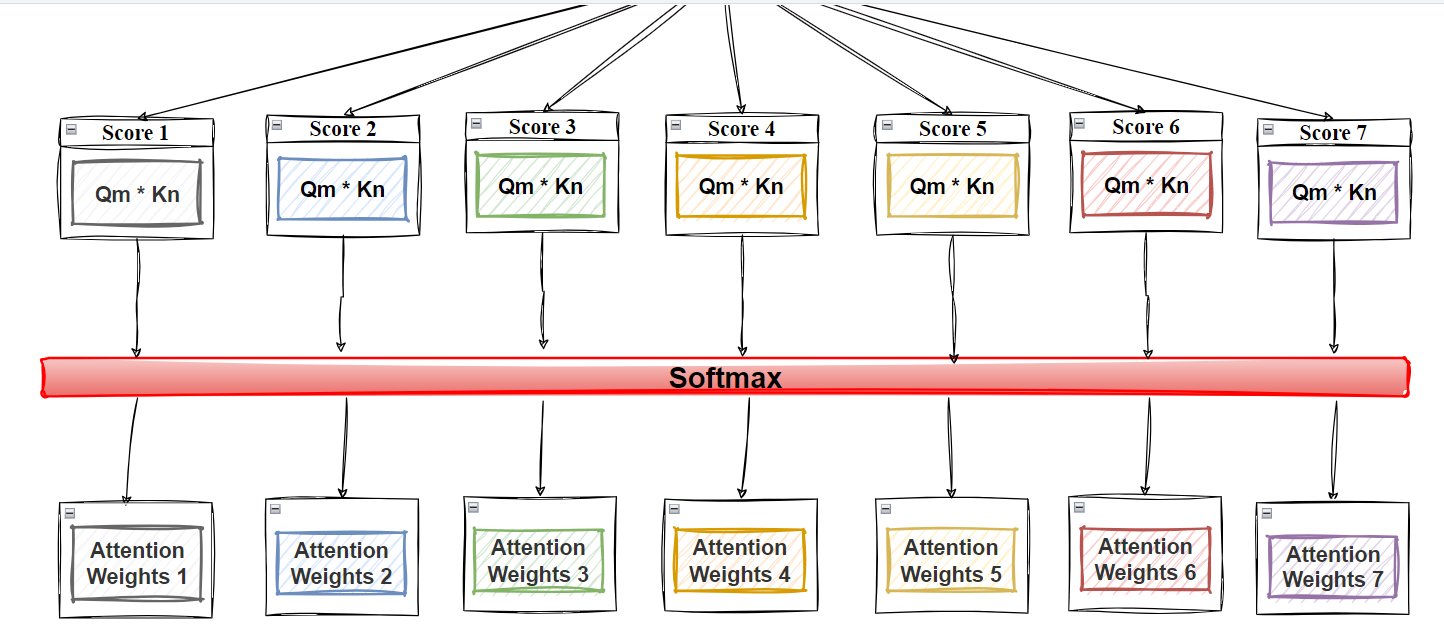

In [22]:
# Normalize scores using softmax
def softmax(scores):
    return torch.nn.functional.softmax(scores, dim=-1)

attention_weights_heads = softmax(attention_scores_heads)
print("\nAttention Weights:")
for head_idx in range(num_heads):
    print(f"Head {head_idx}:")
    for token, weight in zip(tokens, attention_weights_heads[0, head_idx]):
        print(f"{token}: {weight}")


Attention Weights:
Head 0:
Le: tensor([1.])
Head 1:
Le: tensor([1.])


6. **Weighted Sum of Value Vectors**:
   - Each head computes a weighted sum of the Value vectors based on the attention weights, resulting in a context-aware representation for each word.

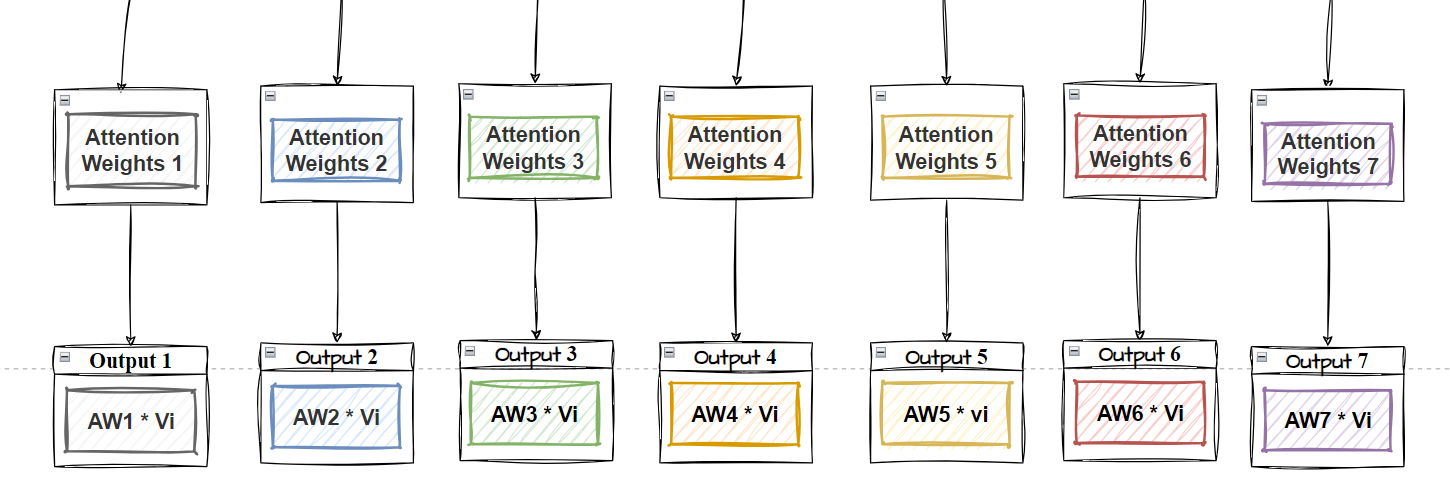

In [23]:
# Compute the weighted sum of Value vectors for each head
def weighted_sum(V, attention_weights):
    return torch.matmul(attention_weights, V)  # Shape: (batch_size, num_heads, seq_length, depth)

output_heads = weighted_sum(V_heads, attention_weights_heads)
print("\nOutput from Each Head:")
for head_idx in range(num_heads):
    print(f"Head {head_idx}:")
    for token, output in zip(tokens, output_heads[0, head_idx]):
        print(f"{token}: {output}")


Output from Each Head:
Head 0:
Le: tensor([0.4000])
Head 1:
Le: tensor([0.5000])


7. **Concatenation of Heads**:
   - After each head computes its output, the outputs are concatenated to form a single vector that contains information from all heads.

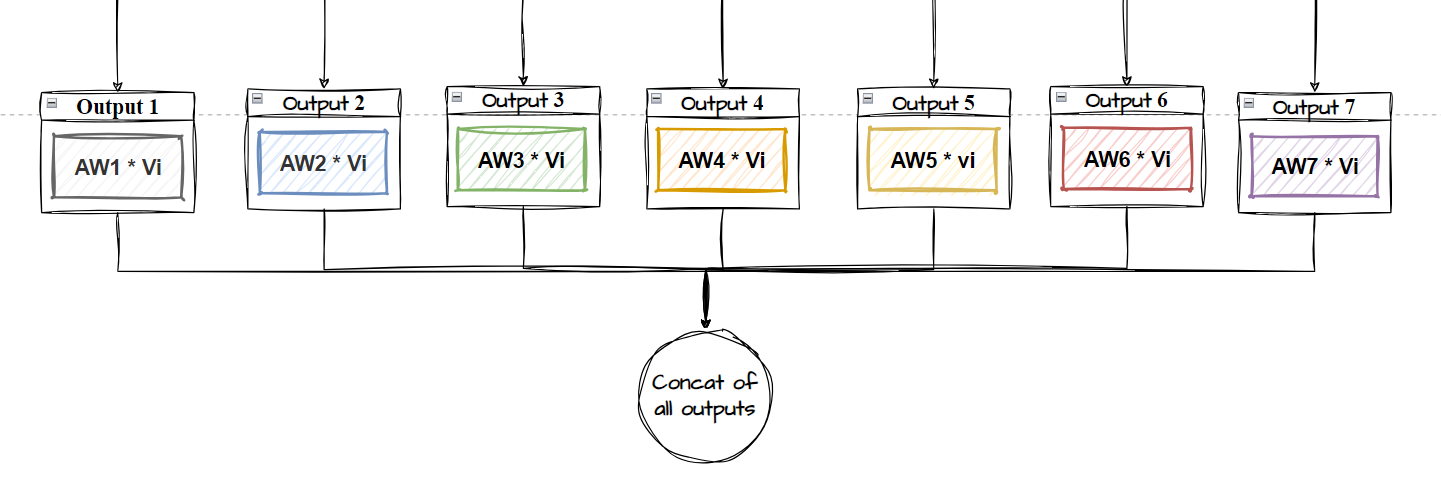

In [24]:
# Concatenate the outputs from all heads
def concat_heads(output):
    batch_size = output.size(0)
    num_heads = output.size(1)
    depth = output.size(3)
    return output.view(batch_size, -1, num_heads * depth)  # Shape: (batch_size, seq_length, num_heads * depth)

concatenated_output = concat_heads(output_heads)
print("\nConcatenated Output:")
for token, output in zip(tokens, concatenated_output[0]):
    print(f"{token}: {output}")


Concatenated Output:
Le: tensor([0.4000, 0.5000])


8. **Final Linear Transformation**:
   - The concatenated output is passed through a final linear transformation to produce the final output for the word.

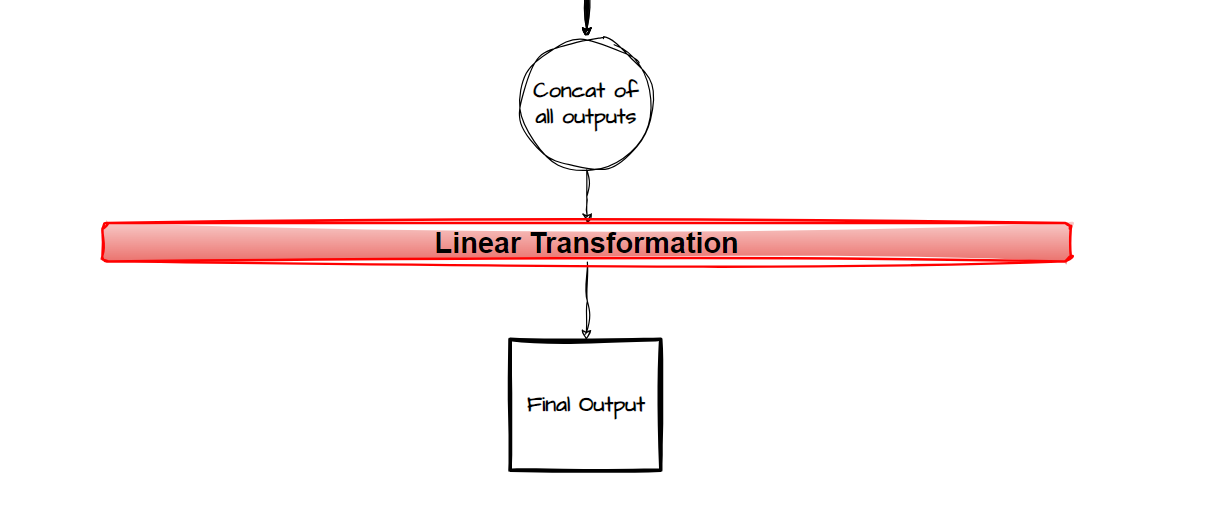

In [26]:
# Define final weight matrix for output
W_O = torch.tensor([[1, 0, 1], [0, 1, 1]], dtype=torch.float32)  # Shape (num_heads * depth, d_model)

# Apply final linear transformation
final_output = torch.matmul(concatenated_output, W_O)  # Shape: (batch_size, seq_length, d_model)
print("\nFinal Output:")
for token, output in zip(tokens, final_output[0]):
    print(f"{token}: {output}")


Final Output:
Le: tensor([0.4000, 0.5000, 0.9000])


- The output tensor `[0.4000, 0.5000, 0.9000]` represents the contextualized embedding of "Le" after applying multi-head attention.
- Each value in the tensor corresponds to a dimension in the embedding space.
- The values indicate the strength of the associations between "Le" and various features or relationships learned by the model during attention computation.

## Conclusion

In this notebook, we explored the concepts of **self-attention** and **multi-head attention**, which are essential components of transformer models used in natural language processing (NLP).

### Key Points Discussed:

- **Self-Attention**:
  - A mechanism that helps the model focus on different words in a sentence by weighing their importance relative to each other.

- **Multi-Head Attention**:
  - An extension of self-attention that uses multiple sets of attention heads. Each head captures different relationships in the input, allowing for a richer understanding of context.

### Practical Implementation:
- We implemented code to demonstrate how self-attention and multi-head attention work using the example of translating the French sentence "Le chat noir mange la souris blanche." 
- The code showed how these mechanisms compute attention scores and generate contextualized embeddings for each word.

### Final Thoughts:
- Understanding self-attention and multi-head attention is crucial for working with transformer models in NLP tasks like translation, summarization, and more.